In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import tqdm as tqdm

In [2]:
labels = pd.read_csv("labels.csv",index_col=[0]).iloc[:,0]
data = pd.read_csv("data.csv",index_col=[0])
bina = pd.read_csv("binary_no_ancestrality.csv",index_col=[0])
bina_a = pd.read_csv("binary_with_ancestrality.csv",index_col=[0])
sims = pd.read_csv("wang_pairwise_similarities.csv",index_col=[0])

sims.index = sims.index.str.replace("DOID:","obo.DOID_")
sims.columns = sims.columns.str.replace("DOID:","obo.DOID_")

dsims = 1-sims

# Pairwise (Dis)Similarities

In [ ]:
sort_dsim = dsims.mean().sort_values().index
sort_sim = sims.mean().sort_values().index

plt.title("Wang Disease Dissimilarities Heat Map")
sns.heatmap(dsims.loc[sort_dsim,sort_dsim])
plt.show()

# Groupwise Dis/Similarities - No ancestrality, No Semantics

In [4]:
groupwise_cosine_sim = pd.DataFrame(cosine_similarity(bina))
groupwise_cosine_dsim = 1 - groupwise_cosine_sim

<AxesSubplot:>

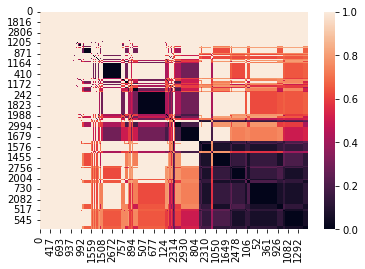

In [5]:
a = groupwise_cosine_dsim.mean().sort_values(ascending = False).index
sns.heatmap(groupwise_cosine_dsim.loc[a,a])

# Groupwise Dis/Similarities - Semantically (Wang et al.,2007) (equation 5 and 6)

In [6]:
bina_a_dict = {i:list(bina_a.T.iloc[:,i][bina_a.T.iloc[:,i] == 1].index) for i in bina_a.index}

In [7]:
#eq 5
def Sim_5(do,P):
    return sims.loc[do,P].max()

#eq 6
def Sim_6(P1,P2):
    
    sum_1 = 0
    sum_2 = 0
    
    m = len(P1)
    n = len(P2)
    
    if m+n == 0:
        return 0
    
    else:
    
        for i in P1:
            sum_1 += Sim_5(i,P1)

        for j in P2:
            sum_2+= Sim_5(j,P2)
        
        return (sum_1 + sum_2)/(m + n)

In [ ]:
groupwise_wang_sims = pd.DataFrame(data=0, index = bina_a.index, columns = bina_a.index)
for i in groupwise_wang_sims.index:
    for j in groupwise_wang_sims.index:
        if i==j:
            groupwise_wang_sims.loc[i,j] = 1
        elif i>j:
            groupwise_wang_sims.loc[i,j] = Sim_6(bina_a_dict[i],bina_a_dict[j])